In [410]:
try:    importlib.reload(Jupytils)
except: import Jupytils
showTopbar("Crystal Ball Examples", menu=[("Help", "#"), ("Home", "#")])

import pymc3 as pymc3
from pymc3 import *
from numpy import median
from scipy import optimize
import openpyxl

<IPython.core.display.Javascript object>

In [429]:
#********** DO NOT USE THIS IF ALL THE TABLE CONTENTS ARE NOT SHOWING
#
cellJAVASCRIPT='''
v2 = $('{}_searchResults')

td = $('{} tr').eq({}).find('td').eq({});
//console.log(r, c,td.text())
td.attr('title', '{}')
td.css('background-color', '{}')
td.css('border', '2px {} solid')
td.focusin (function(){{
    v2.text($(this).attr('title'))
//    console.log('sadass')
}});
'''
def getOurCodedCells(df2):
    detrs = {}
    probs = {}
    for i, r in df2.iterrows():
        cc= -1;
        for j, c in r.iteritems():
            c = str(c).strip()
            cc += 1;
            if ( c.startswith('::PROB::') ):
                probs[(i+1, cc+1)] = c;
            elif ( c.startswith('::DETR::') ):
                detrs[(i+1, cc+1)] = c;
    return probs, detrs


def setCellFormat(df2, dictItems={}, background='', border='blue'):
    scr = "<script>\n"
    tableID = "#"+ df2.tableID
    for k, f in dictItems.items(): 
        c1, c2 = k
        ff = f.replace("'", r"\'")
        scr += cellJAVASCRIPT.format(tableID,tableID, c1,c2-1,ff, background, border)
    scr+="</script>\n"

    display(HTML(scr))
    
def HighlightDF(df2):
    probs, detrs = getOurCodedCells(df2)
    
    setCellFormat(df2, df2.formulas,'', 'blue')
    setCellFormat(df2, probs,'', 'green')
    setCellFormat(df2, detrs,'', 'cyan')
    return probs, detrs, df2.formulas
    
def showExcelDF(df2):
    if (len(df2) > 500):
        return "Max Rows Exceeded"
    displayDFs(df2, showIcons=False, maxrows=len(df2));

    probs, detrs, df2.formulas = HighlightDF(df2)
    return probs, detrs, df2.formulas



In [430]:
fileName="Examples/Cell Phone.xlsx"; sheetname='Model'
#fileName="nogit/lrp/fin.xlsx";sheetname='Crystal Ball Model'
df2= LoadDataSet(fileName, sheetname=sheetname)
p,d,f = showExcelDF(df2)

,A,B,C,D,E,F,G,H,I
0,,Deciding on a Monthly Cell Phone Plan,,,,,,,Learn about model
1,,,,,,,,,
2,,,Cellular World,Freedom Cell,,,,,"::PROB::D11::Normal::{mu: 400, sd:20}"
3,,Base Fee,39.990,35,,,,,"::PROB::D12::Triangular::l::{1:.1, h:.4,m:.3}"
4,,Included Minutes,400,Unlimited,,,,,::DETR::D14::ROIFunction()
5,,Additional Minutes,0.400,0,,,,,
6,,Long Distance,0,0.080,,,,,
7,,Total Cost,39.990,44.600,,,,,
8,,,,,,Assumption parameters,,,
9,,,,Assumptions,,Parm 1,Parm 2,Parm 3,Distribution


In [398]:
tableID = "#"+ df2.tableID
tdh=r'''
<select id="proexample">
    <option value=""></option>
    <option value="Normal(\'Name\', mu=0, sd=0 )">Normal(\'Name\', mu=0, sd=0 )</option>
    <option value="Triangular(\'Name\', l=.1, h=.5,max=.7 )">Triangular(\'Name\', l=.1, h=.5,max=.7 )</option>
</select><br/>
<input type="text" id="protext">

'''
td = '''
<script>
td=$('{} tr').eq({}).find('td').eq({});
td.val();
td.html('{}')
</script>
<script>
$("#proexample").on("change",function() {{
    var v = this.value;
    if (v=="") return; 

    $('#protext').val(v); 
  }}); 
</script>  
'''.format(tableID,7,8,tdh.replace('\n',''))


display(HTML(td))

td

'\n<script>\ntd=$(\'#tableID_1506303875193 tr\').eq(7).find(\'td\').eq(8);\ntd.val();\ntd.html(\'<select id="proexample">    <option value=""></option>    <option value="Normal(\\\'Name\\\', mu=0, sd=0 )">Normal(\\\'Name\\\', mu=0, sd=0 )</option>    <option value="Triangular(\\\'Name\\\', l=.1, h=.5,max=.7 )">Triangular(\\\'Name\\\', l=.1, h=.5,max=.7 )</option></select><br/><input type="text" id="protext">\')\n</script>\n<script>\n$("#proexample").on("change",function() {\n    var v = this.value;\n    if (v=="") return; \n\n    $(\'#protext\').val(v); \n  }); \n</script>  \n'

In [197]:
def roi(nunits, opcost, rent=500):
    return nunits * rent - opcost

with pymc3.Model() as mcmc:
    nunits = pymc3.Uniform('Number Of Units', 30, 40)
    #opcost = pymc3.Normal('Operating Cost', mu=15000, tau=1/(1000*1000) )
    opcost = pymc3.Normal('Operating Cost', mu=15000, sd=1000 )
    ROI = Deterministic('ROI', roi(nunits=nunits, opcost=opcost, rent=500) )
    
    # obtain starting values via MAP
    start = find_MAP(fmin=optimize.fmin_powell)
    # instantiate sampler
    step = NUTS(scaling=start)
    # draw 2000 posterior samples
    traced = sample(10000, step, start=start)
    
    #traced = sample(1000)


INFO (theano.gof.compilelock): Refreshing lock /Users/snarayan/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.5.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/snarayan/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.5.3-64/lock_dir/lock


Optimization terminated successfully.
         Current function value: 9.212988
         Iterations: 1
         Function evaluations: 31


  0%|          | 0/10000 [00:00<?, ?it/s]INFO (theano.gof.compilelock): Refreshing lock /Users/snarayan/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.5.3-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/snarayan/.theano/compiledir_Darwin-15.6.0-x86_64-i386-64bit-i386-3.5.3-64/lock_dir/lock
100%|██████████| 10000/10000 [00:08<00:00, 1154.63it/s]


2480.15634717 1728.59291194
2480.15634717 1728.59291194


0.92432557952960004

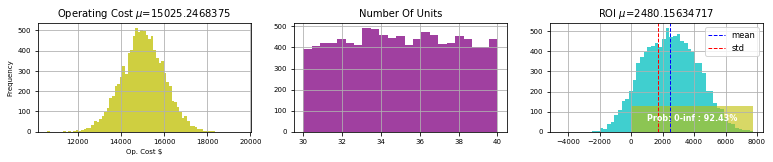

In [204]:
plt.figure(figsize=(13,2))
mn = np.mean(traced['Operating Cost'])
plthist(traced['Operating Cost'], title='Operating Cost $\mu$='+ str(mn), ylabel='Frequency', xlabel='Op. Cost $', facecolor='y', subplot=131);
#n1 = [norm(15000, 1000).rvs() for i in range(1000)]
#plthist(n1, facecolor='r', alpha=0.3,subplot=131);
plthist(traced['Number Of Units'], title='Number Of Units', subplot=132, facecolor='purple')
mn = np.mean(traced['ROI'])

plthist(traced['ROI'], title='ROI $\mu$=' + str(mn), subplot=133, facecolor='c', ablines=['mean', 'std'], legend=True, low=0, high=np.math.inf)

NormProb(traced['ROI'], 0, 80000)

In [ ]:
for j in traced.varnames:
    print(j)

In [ ]:
from pymc3 import traceplot
traceplot(traced);